In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import pickle
import os.path

import qiskit
from qiskit import Aer
from qiskit import IBMQ
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.circuit import Parameter
from qiskit.providers.aer import noise
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

# some definitions of gate unitaries
s0 = np.array([[1,0],[0,1]])
sx = np.array([[0,1],[1,0]])
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])
s = np.array([sx, sy, sz])
h = np.array([[1,1],[1,-1]])/np.sqrt(2)

# number of qubits in the quantum circuit
n_qubits = 5

In [26]:
# some helpful functions

# get_bin converts an integer x to a binary number with (n_qubits-1) bits, i.e. get_bin(3) -> '011' 
get_bin = lambda x, n=(n_qubits-1): format(x, 'b').zfill(n)

def ret(dictionary, key):
    if key in dictionary:
        return dictionary[key]
    else:
        return 0
def next_file(filename, file_extension="pdf", folder="figures5_draft", replace_last=True):
    """
    Return another filename with increased index. If files '0_filename.pdf' and '1_filename.pdf' already exist, 
    and if replace_last=False, this function will return '2_filename.pdf'. In the case, where replace_last=True,
    it will return the last existing filename, i.e. '1_filename.pdf' in above example.
    """
    idxx = 0
    while(True):
        ff = f"{folder}/{idxx}_{filename}.{file_extension}"
        if not os.path.exists(ff):
            break
        idxx += 1
    if replace_last and idxx > 0:
        ff = f"{folder}/{idxx-1}_{filename}.{file_extension}"
    return ff

In [3]:
IBMQ.load_account()

provider = IBMQ.get_provider(group='open')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

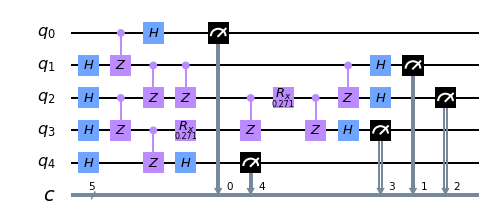

In [38]:
# the range of parameters (alpha) to consider
alphas = np.linspace(0.01,2*np.pi-0.01,25)

# two different sets of data, one for symmetry preserving perturbtions and one for symmetry breaing perturbation
sets=[0,1,2,3]
n_sets = len(sets)
submit = [] # this list will store all circuits
initial_state = 0 # 
state = ['|0>','|1>','|+>','|->','|y+>','|y->']
psi_in = np.zeros(2)
symstring = ["","","id",""]

# measurement circuit of all but the last qubit
# everything is measured in x-basis
m = QuantumCircuit(n_qubits,n_qubits)
for i in np.arange(n_qubits-1):
    m.h(i)

m.measure(range(n_qubits-1),range(n_qubits-1))

# tomography on the last qubit, i.e. measurement along x,y,z
mz = QuantumCircuit(n_qubits,n_qubits)
mz.measure(n_qubits-1,n_qubits-1)

mx = QuantumCircuit(n_qubits,n_qubits)
mx.h(n_qubits-1)
mx.measure(n_qubits-1,n_qubits-1)

my = QuantumCircuit(n_qubits,n_qubits)
my.sdg(n_qubits-1)
my.h(n_qubits-1)
my.measure(n_qubits-1,n_qubits-1)

# define the main circuit for different symmetry in [True,False]
# and for all alphas

for symmetry in sets:
    for alpha in alphas: 
        circuit = QuantumCircuit(n_qubits,n_qubits)

        # define initial state 
        #circuit.h(0)
        #circuit.sdg(0)
        #circuit.x(0)
        #circuit.h(0)
        if initial_state == 0:
            psi_in = np.array([1,0])
        elif initial_state == 1:
            circuit.x(0)
            psi_in = np.array([0,1])
        elif initial_state == 2:
            circuit.h(0)
            psi_in = np.array([1,1])/np.sqrt(2)
        elif initial_state == 3:
            circuit.x(0)
            circuit.h(0)
            psi_in = np.array([1,-1])/np.sqrt(2)
        elif initial_state == 4:
            circuit.h(0)
            circuit.s(0)
            psi_in = np.array([1,1j])/np.sqrt(2)
        elif initial_state == 5:
            circuit.h(0)
            circuit.sdg(0)
            psi_in = np.array([1,-1j])/np.sqrt(2)

            
        for i in np.arange(1,n_qubits):
            circuit.h(i)
        circuit.cz(0,1)
        circuit.cz(2,3)
        circuit.cz(1,2)
        circuit.cz(3,4)

        ###############################
        # unitary goes in here
        ###############################
        # 0 - symm preserving (long)
        # 1 - symm breaking (long)
        # 2 - id
        # 3 - symm breaking (short)
        many_qubit = ""
        single_qubit = "id"
        
        if symmetry == 0: # symmetry preserving single unitary
            circuit.rx(alpha, 3)
            single_qubit = r"$R_x(\alpha)_4$"
        if symmetry == 2: # symmetry preserving single unitary
            circuit.rx(-alpha, 3)
            single_qubit = r"$R_x(-\alpha)_4$"
        if symmetry == 1: # symmetry breaking single unitary
            circuit.ry(alpha, 3)
            single_qubit = r"$R_y(\alpha)_4$"
        if symmetry == 3: # symmetry breaking single unitary
            circuit.ry(-alpha, 3)
            single_qubit = r"$R_y(-\alpha)_4$"
        # symmetry preserving multi unitary
        circuit.cz(1,2)
        circuit.cz(2,3)
        circuit.rx(alpha, 2)
        circuit.cz(2,3)
        circuit.cz(1,2)
        many_qubit = r"$exp(i\alpha Z_2 X_3 Z_4)$"
                

        # description the symmetry preserving unitary, this string is printed as a plotlabel
        symstring[symmetry] = many_qubit + single_qubit
        ##############################
        ##############################

        submit.append(circuit+m+mx)
        submit.append(circuit+m+my)
        submit.append(circuit+m+mz)


def drawcircuits(circuits, selected):
    for i in selected:
        f1 = plt.figure(); ax = f1.add_subplot(111);
        circuits[i].draw(idle_wires=False, output='mpl',scale=0.5, ax=ax)
        
# print somce circuits to see if everything is implemented correctly
# choose first 3 circuits of first half (symmetry preserving, alpha=0)
# and choose first 3 circuits of second half (symmetry brealing, alpha=0)
print_selected = np.array([3])
drawcircuits(submit, print_selected)

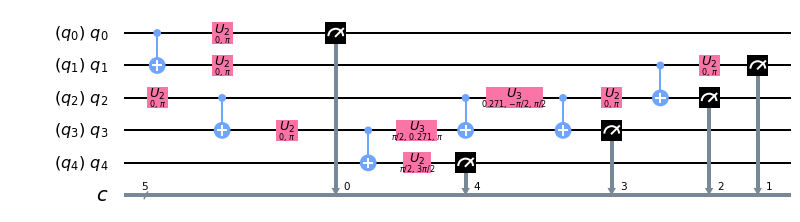

In [39]:
qc='ibmq_16_melbourne'
#qc='ibmqx2'
#qc = 'ibmq_qasm_simulator'
olevel = 1
nshots = 8192//4
namestring = str(len(alphas)) + qc + " " + str(n_qubits) + f" OL {olevel}, {state[initial_state]}, {nshots} shots"
initial_layout=[0,1,2,3,4] # define mapping of virtual qubits to pysical qubits

sim_backend = provider.get_backend(qc)
submit_t = transpile(submit, backend=sim_backend,optimization_level=olevel, initial_layout=initial_layout)

# print to check the transpiled circuit
# for alpha = alphas[0]
print_figs = [4]#[0,1,2,3,4,5]#len(submit_t)//2,len(submit_t)//2+1,len(submit_t)//2+2]
for i in print_figs:
    f1 = plt.figure(); ax = f1.add_subplot(111);
    submit_t[i].draw(idle_wires=False, output='mpl',scale=0.5, ax=ax)

In [40]:
qr = qiskit.QuantumRegister(5)
meas_calibs, state_labels = complete_meas_cal(qubit_list=initial_layout, qr=qr, circlabel='mcal')
job_calib = qiskit.execute(meas_calibs, backend=sim_backend, shots=8192)

# I use the jobmanager to submit all jobs necessary to create one figure at once. this will automatically split up
# submit_t, that contains all transpiled circuits, into jobs of 75 circuits each. The maximum number of allowed jobs 
# in the queue is 5, which amounts to 5*75=375 circuit. Once should make sure that n_sets*len(alphas)*3 is less than 375
job_manager = IBMQJobManager()
job_exp = job_manager.run(submit_t, backend=sim_backend, name=namestring, shots=nshots, max_experiments_per_job=75*4,optimization_level=olevel)
"""
# Generate a noise model for the 5 qubits
noise_model = noise.NoiseModel()
for qi in initial_layout:
    read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
    noise_model.add_readout_error(read_err, [qi])

job_exp = qiskit.execute(submit_t, Aer.get_backend('qasm_simulator'), shots=nshots, noise_model=noise_model)
result = job_exp.result()
#""";

In [ ]:
job_monitor(job_calib)
for j in np.arange(len(job_exp.jobs())):
    job_monitor(job_exp.jobs()[j])
    
result = job_exp.results()
cal_results = job_calib.result()
replace_last = False 

# measurement error mitigation
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=initial_layout, circlabel='mcal')
plt.imshow(meas_fitter.cal_matrix,vmin=0,vmax=1)
plt.colorbar()
print(np.diag(meas_fitter.cal_matrix))
meas_filter = meas_fitter.filter

Job Status: job is queued (1)

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)
f = np.zeros((n_sets,len(alphas)), dtype=complex)

plt.figure(figsize=(10,5))
for mitigate in [True,False]:
    plt.subplot(1,2,int(mitigate)+1)
    for j in np.arange(n_sets):
        for a in np.arange(len(alphas)):            
            # arrays store measurements of |0> and |1> for all three axes
            up = np.zeros(3)
            down = np.zeros(3)
            for axis in np.arange(3):
                r_raw = result.get_counts(int(j*3*len(alphas) + 3*a + axis))
                if mitigate:
                    r = meas_filter.apply(r_raw)
                else:
                    r = r_raw
                for i in np.arange((n_qubits-1)**2):
                    # the first (n_qubits-1) qubits are all measured in x basis
                    # the pauli corrections will be different depending on the measurement outcomes
                    # we therefor loop through all of the (n_qubits-1)**2 different outcomes

                    # convert i to binary and extracted results s1, s2, ... 
                    binary = get_bin(i)
                    s1 = int(binary[-1])
                    s2 = int(binary[-2])
                    s3 = int(binary[-3])
                    s4 = int(binary[-4])
                    
                    if axis == 0:
                        factor = (-1)**(s1+s3)
                    elif axis == 1:
                        factor = (-1)**(s1+s2+s3+s4)
                    else:
                        factor = (-1)**(s2+s4)
                    
                    if factor == 1: 
                        up[axis] += ret(r,'0'+binary)
                        down[axis] += ret(r,'1'+binary)
                    else: 
                        down[axis] += ret(r,'0'+binary)
                        up[axis] += ret(r,'1'+binary)
            # perform quantum state tomography on the last qubit
            rho_exp = 0.5 * np.array(s0, dtype= complex)
            for axis in np.arange(3):
                rho_exp += 0.5 * (up[axis]-down[axis])/(up[axis]+down[axis]) * s[axis]
            f[j,a] = state_fidelity(psi_in, rho_exp)
        plt.plot(alphas, f[j].real, '.-', label=symstring[j])
    plt.title(namestring + f"\n layout " + str(initial_layout) + f"\n{job_exp.jobs()[0].job_id()}")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("Fidelity")
    if mitigate:
        f_min = np.min(np.min(f.real))*0.85
        f_max = np.max(np.max(f.real))*1.1
    plt.ylim((0, min(f_max, 1.1)))
    plt.legend()
    plt.tight_layout()


# save all figures to new file (or replace last file if replace_last=True)
# the job_id in the plot title allows us to retrieve the data from the IBM server to replot the figure in high quality
plt.savefig(next_file("sim", file_extension="pdf", replace_last=replace_last))
plt.savefig(next_file("sim", file_extension="jpg", replace_last=replace_last))
submit[0].draw(output='mpl', filename=next_file("a_sim",file_extension="png", replace_last=replace_last))
submit[len(submit)//2].draw(output='mpl', filename=next_file("b_sim",file_extension="png", replace_last=replace_last))
submit_t[0].draw(output='mpl', idle_wires=False, filename=next_file("a_transpiled",file_extension="png", replace_last=replace_last))
submit_t[len(submit_t)//2].draw(output='mpl', idle_wires=False, filename=next_file("b_transpiled",file_extension="png", replace_last=replace_last))
replace_last = True


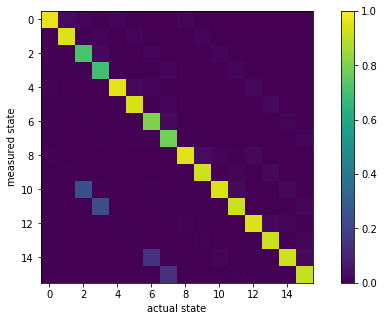

In [120]:
plt.imshow(meas_fitter.cal_matrix,vmin=0,vmax=1)
plt.colorbar()
plt.xlabel("actual state")
plt.ylabel("measured state")
plt.savefig("measurement_calibration5.png")